In [1]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

O arquivo “bbc_text_cls.csv” já existe, não será baixado.



In [2]:
!pip install transformers

In [88]:
from transformers import pipeline

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, recall_score, precision_score

from typing import List

In [4]:
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
classifier("this is a great movie", candidate_labels=["positive", "negative"])

{'sequence': 'this is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9962115287780762, 0.003788488684222102]}

In [6]:
# https://en.wikipedia.org/wiki/AMP-activated_protein_kinase
text = "Due to the presence of isoforms of its components, there are 12 " + \
  "versions of AMPK in mammals, each of which can have different tissue " + \
  "localizations, and different functions under different conditions. " + \
  "AMPK is regulated allosterically and by post-translational " + \
  "modification, which work together."
classifier(text, candidate_labels=["biology", "math", "geology"])

{'sequence': 'Due to the presence of isoforms of its components, there are 12 versions of AMPK in mammals, each of which can have different tissue localizations, and different functions under different conditions. AMPK is regulated allosterically and by post-translational modification, which work together.',
 'labels': ['biology', 'math', 'geology'],
 'scores': [0.8908607959747314, 0.06606560200452805, 0.04307366907596588]}

In [7]:
df = pd.read_csv("bbc_text_cls.csv")
len(df)

2225

In [8]:
df.sample(frac=1.0).head()

,text,labels
710,Triple triumph for Little Britain\n\nTop TV cu...,entertainment
1578,Benitez 'to launch Morientes bid'\n\nLiverpool...,sport
866,Aviator and Vera take Bafta glory\n\nHollywood...,entertainment
277,SBC plans post-takeover job cuts\n\nUS phone c...,business
1519,Arnesen denies rift with Santini\n\nTottenham ...,sport


In [9]:
# labels = list(set(df["labels"]))
labels = df["labels"].unique().tolist()
labels

['business', 'entertainment', 'politics', 'sport', 'tech']

In [10]:
print(textwrap.fill(df.iloc[1024]['text']))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [11]:
df.iloc[1024]['labels']

'politics'

In [12]:
classifier(df.iloc[1024]['text'], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [13]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)
    preds = classifier(df['text'].tolist(), candidate_labels=labels)

In [15]:
preds[0]

{'sequence': 'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and wi

In [16]:
predicted_labels = [d["labels"][0] for d in preds]
predicted_labels[0]

'business'

In [17]:
df['predicted_labels'] = predicted_labels

In [18]:
print(f"acc.: {np.mean(df['predicted_labels'] == df['labels'])}")

acc.: 0.5649438202247191


In [111]:
# Convert prediction probs into N x K matrix according to original label order


def getProbsMatrix(
    df: pd.DataFrame, labels: List[str], pipeline_results: List[str], labels_col: str
):
    print(labels)
    N = len(df)
    K = len(labels)

    print(f"N: {N}\t K: {K}")

    label2idx = {l: i for i, l in enumerate(labels)}

    df["labels_int"] = df[labels_col].apply(lambda l: label2idx[l])

    probs = np.zeros((N, K))
    for n in range(N):
        for label in pipeline_results[n]["labels"]:
            label_pos = pipeline_results[n]["labels"].index(label)
            probs[n, label2idx[label]] = pipeline_results[n]["scores"][label_pos]

    return probs


probs = getProbsMatrix(df, labels, pipeline_results=preds, labels_col="labels")


def getStatistics(df: pd.DataFrame, probs_matrix: np.ndarray):
    # Compute accuracy
    accuracy = np.mean(np.argmax(probs_matrix, axis=1) == df["labels_int"])
    print("Accuracy: {:.6f}".format(accuracy))

    # Compute precision, recall, and F1
    f1 = f1_score(df["labels_int"], np.argmax(probs_matrix, axis=1), average="weighted")
    print("F1: {:.6f}".format(f1))

    recall = recall_score(
        df["labels_int"], np.argmax(probs_matrix, axis=1), average="weighted"
    )
    print("Recall: {:.6f}".format(recall))

    precision = precision_score(
        df["labels_int"], np.argmax(probs_matrix, axis=1), average="weighted"
    )
    print("Precision: {:.6f}".format(precision))

    # Compute confusion matrix
    cm = confusion_matrix(
        y_true=df["labels_int"],
        y_pred=np.argmax(probs_matrix, axis=1),
        normalize="true",
    )
    print("Confusion matrix:")
    print(cm)

    return accuracy, f1, recall, precision, cm


accuracy, f1, recall, precision, cm = getStatistics(df, probs)


['business', 'entertainment', 'politics', 'sport', 'tech']
N: 2225	 K: 5
Accuracy: 0.564944
F1: 0.560391
Recall: 0.564944
Precision: 0.611344
Confusion matrix:
[[0.7627451  0.00588235 0.1627451  0.03529412 0.03333333]
 [0.38341969 0.41709845 0.03626943 0.02590674 0.1373057 ]
 [0.0911271  0.00719424 0.79136691 0.02398082 0.08633094]
 [0.38943249 0.06457926 0.02739726 0.44618395 0.07240705]
 [0.35411471 0.20199501 0.03740648 0.03491272 0.37157107]]


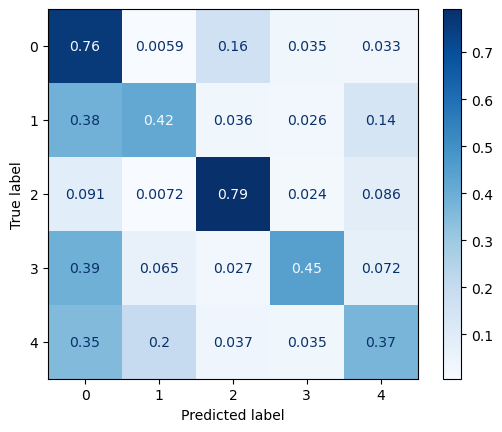

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

In [92]:
label2idx = {l: i for i, l in enumerate(labels)}
int_labels = [label2idx[l] for l in df['labels']]

In [93]:
int_preds = np.argmax(probs, axis=1)

In [96]:
# cm_lesson is just the code from lesson, different from mine code: cm
cm_lesson = confusion_matrix(int_labels, int_preds, normalize='true')
cm_lesson

array([[0.7627451 , 0.00588235, 0.1627451 , 0.03529412, 0.03333333],
       [0.38341969, 0.41709845, 0.03626943, 0.02590674, 0.1373057 ],
       [0.0911271 , 0.00719424, 0.79136691, 0.02398082, 0.08633094],
       [0.38943249, 0.06457926, 0.02739726, 0.44618395, 0.07240705],
       [0.35411471, 0.20199501, 0.03740648, 0.03491272, 0.37157107]])

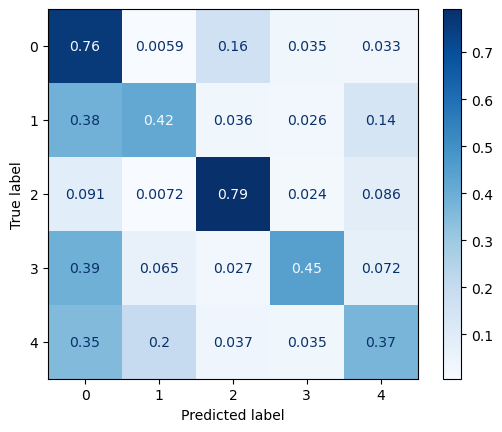

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=cm_lesson).plot(cmap='Blues')

In [63]:
# Exercise:
# Try this with airline sentment dataset
# Compare with actual sentiment analyser
# The result should be surprising!

In [82]:
at_data = pd.read_csv("AirlineTweets.csv")
at_data.shape

(14640, 15)

In [83]:
at_data = at_data[['airline_sentiment', 'text']].copy()

In [84]:
available_sentiments = at_data["airline_sentiment"].unique().tolist()
available_sentiments

['neutral', 'positive', 'negative']

In [85]:
available_sentiments.remove('neutral')
available_sentiments

['positive', 'negative']

In [87]:
print(f"Rows with neutral: {len(at_data)}")
at_data = at_data[at_data['airline_sentiment'] != 'neutral']
print(f"Rows without neutral: {len(at_data)}")

Rows with neutral: 14640
Rows without neutral: 11541


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)
    at_preds = classifier(at_data['text'].tolist(), candidate_labels=available_sentiments)

In [99]:
at_predicted_labels = [p["labels"][0] for p in at_preds]
at_predicted_labels[0]

'negative'

In [100]:
at_data["predicted_labels"] = at_predicted_labels

In [102]:
print(f"Acc.: {np.mean(at_data['predicted_labels'] == at_data['airline_sentiment'])}")

Acc.: 0.9158651763278746


['positive', 'negative']
N: 11541	 K: 2
Accuracy: 0.915865
F1: 0.919132
Recall: 0.915865
Precision: 0.928215
Confusion matrix:
[[0.91917055 0.08082945]
 [0.08498584 0.91501416]]


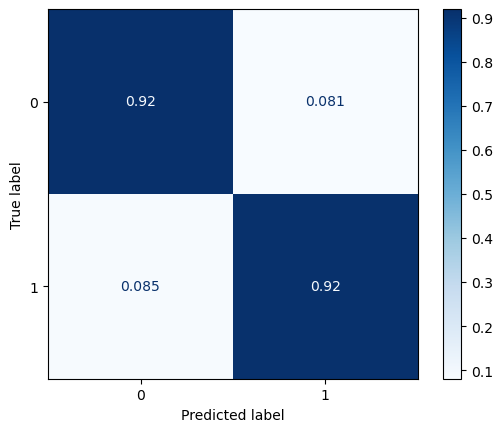

In [114]:
probs = getProbsMatrix(
    at_data,
    available_sentiments,
    pipeline_results=at_preds,
    labels_col="airline_sentiment",
)
accuracy, f1, recall, precision, cm = getStatistics(at_data, probs)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
